**MDS7203 Modelos Generativos Profundos, Primavera 2023**

# Laboratorio 4: Modelos basados en score

**Profesor**: Felipe Tobar

**Auxiliares**: Cristóbal Alcázar, Camilo Carvajal Reyes.

**Ayudante**: Joaquín Barceló.

**Estudiante**: Sebastián Sanhueza

## (P1) Muestreo de Langevin

La clase `GaussianMixture`se muestra completa a continuación, conteniendo los métodos requeridos en cada pregunta junto con los métodos adicionales. El diseño de esta clase se especificará después del código, explicando su desarrollo a partir de cada pregunta de esta primera parte.

In [ ]:
# Librerias
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss

In [ ]:
class GaussianMixture():
  """Clase que permite trabajar con una distribución de mixturas gaussianas.
     Permite extraer muestras, calcular su pdf, calcular la función score,
     extraer muestras mediante Langevin Dynamics y graficar la pdf, función score
     y las muestras últimas.

  """

  def __init__(self, means, covariances, weights):
    """Inicializa la instancia de la clase. Verifica que los largos de los parámetros
       de la mixtura de gaussianas sean iguales y, si es así, guarda los parámetros como
       variables de la clase.

      Parameters:
      -----------
      means: ndarray
         Arreglo con las medias de las distribuciones multivariadas.

      covariances: ndarray
         Arreglo con las matrices de covarianza de las distribuciones multivariadas.

      weights: ndarray
         Arreglo con los pesos o probabilidades de cada componenete que forma la
         mixtura gaussiana.

      Returns:
      -----------
      None

      Raises:
      -----------
      ValueError: Se lanza una excepción si los largos de los parámetros de entrada
                  no son iguales.

    """
    # Verifica que las dimensiones de los parámetros coincidan
    if len(means) != len(covariances) or len(means) != len(weights):
      raise ValueError("Las listas de medias, covarianzas y pesos deben tener la misma longitud.")
    # Guarda los parámetros
    self.means = means
    self.covariances = covariances
    self.weights = weights
    self.num_components = len(weights) # Se registra la cantidad de componentes



  def sample(self, num_samples=1000):
    """Genera muestras a partir de una mixtura de gausianas.

    Parameters:
    ---------------------------
    num_samples: int (default:1000)
           Cantidad de muestras de interés.

    Returns:
    ---------------------------
    samples: ndarray
           Arreglo con las muestras generadas.

    """
    samples = np.empty((num_samples, self.means[0].shape[0]))
    component_indices = np.random.choice(a=self.num_components, size=num_samples, replace=True, p=self.weights)
    for i, k in enumerate(component_indices):
      # Se generan las muestras a partir de uan distribución gaussiana multivariada
      samples[i] = ss.multivariate_normal.rvs(mean=self.means[k], cov=self.covariances[k])

    return samples



  def pdf(self, x):
    """Calcula la densidad de probabilidad para un arreglo de muestras.

    Parameters:
    ---------------------------
    x: ndarray
      Muestras para calcular su densidad de probabilidad.

    Returns:
    ---------------------------
    pdf_values: ndarray
           Arreglo con las densidades de probabilidad de las muestras.

    """
    pdf_values = np.zeros_like(x[..., 0])
    for k in range(self.num_components):
      pdf_values += self.weights[k] * ss.multivariate_normal.pdf(x, mean=self.means[k], cov=self.covariances[k])

    return pdf_values



  def score(self, x):
    """Opera la score function de una mixtura de gaussianas. Se aplica directamente
       la fórmula desarrollada de la score function.

    Parameters:
    ---------------------------
    x: ndarray
        Muestras para calcular los score de la distribución.

    Returns:
    ---------------------------
    score_values: ndarray
        Arreglo con los score de la mixtura gaussiana.

    """
    l=len(x)
    num_values = np.zeros((l,2))
    for k in range(self.num_components):
      # Los valores de score se obtienen utilizando la forma desarrollada de la function score
      num_values += (self.weights[k]*ss.multivariate_normal.pdf(x, mean=self.means[k], cov=self.covariances[k]))[:,np.newaxis]*(np.dot(-(x-self.means[k]), np.linalg.inv(self.covariances[k])))
    score_values = (self.pdf(x)**-1)[:,np.newaxis]*num_values
    return score_values



  def langevin_samplig(self, num_samples, epsilon, T, plot=True):
    """Realiza el método de muestreo de Langevin Dynamics de una
       distribución de mixturas gaussianas.

    Parameters:
    ---------------------------
    num_samples: int
        Cantidad de muestras para actualizar.

    epsilon: int or float
        Paso fijo del método de Langevin Sampling.
    T: int
       Cantidad de pasos máxima.

    Returns:
    ---------------------------
    samples: ndarray
        Arreglo con el historial de cada actualización de los samples.

    """

    # Inicializa las muestras
    samples = [np.random.standard_normal(size=(num_samples, 2))]  # Función prior π(x)
    # Se inicia el loop de iteraciones
    for t in range(T):
        current_samples = samples[-1]  # Obtiene las muestras más recientes
        gradient = self.score(current_samples) # Obtiene los gradientes de las muestras actuales

        updated_samples = np.copy(current_samples)  # Copia las muestras actuales
        # Recorre cada una de las muestras actuales para la actualización individual
        for i in range(num_samples):
            x_t = current_samples[i]
            z_t = np.random.randn(2)  # Muestra una variable aleatoria desde una distribución normal estándar

            # Actualiza la muestra utilizando la regla de Langevin Dynamics
            x_t1 = x_t + epsilon*gradient[i] + np.sqrt(2*epsilon)*z_t
            updated_samples[i] = x_t1

        samples.append(updated_samples)  # Agrega las muestras actualizadas a la lista

    # Convierte la lista de muestras en un arreglo de NumPy
    samples = np.array(samples)
    # Si plot es True se genera el gráfico de las trayectorias de las muestras
    if plot:
      # Itera a través de las muestras y traza sus trayectorias
      for i in range(samples.shape[1]):
        x_values = samples[:,i][:, 0]
        y_values = samples[:,i][:, 1]
        # Colocar una estrella en el sample final
        plt.plot(x_values[-1], y_values[-1], '*', markersize=10, color='k')
        plt.plot(x_values, y_values)

      # Agrega etiquetas
      plt.xlabel('Eje X')
      plt.ylabel('Eje Y')
      plt.title('Trayectorias de Muestras Langevin')
      plt.grid(True)

      plt.show()

    return samples



  def plot_pdf_score(self, scores=False, num_points=100, num_points_score=20, num_samples=1000):
    """Grafica la función de densidad de probabilidad a partir de muestras
       de una mixtura gausiana junto con la función de score de la distribución.

    Parameters:
    ---------------------------
    scores: bool (default:False)
         Si es True, plotea el gráfico con los valores de score. Si es False no
         los plotea.

    num_points: int (default:100)
           Cantidad de puntos de cada eje para generar la función de densidad
           de probabilidad.

    num_points_score:int (default:20)
           Cantidad de puntos de cada eje para generar los vectores de la función score.

    num_samples: int (default:1000)
           Cantidad de muestras de interés.

    Returns:
    ---------------------------
    None

    """
    # Genera la grilla para graficar la pdf de la distribución
    samples=self.sample(num_samples=num_samples)
    x_range=samples[:,0]
    y_range=samples[:,1]
    x = np.linspace(x_range.min(), x_range.max(), num_points)
    y = np.linspace(y_range.min(), y_range.max(), num_points)
    x, y = np.meshgrid(x, y)
    pos = np.dstack((x,y))
    # Obtiene los valores de la pdf a partir de las muestras de la grilla
    pdf_values = self.pdf(pos)

    fig = plt.figure(figsize=(12, 5))

    # Gráfico 2d de la función de densidad de probabilidad
    ax1 = fig.add_subplot(121)
    contours = ax1.contourf(x, y, pdf_values, levels=50, cmap='viridis')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_title('Gráfico 2D de la Gaussian Mixture PDF')
    # Grafico 3d de la función de densidad de probabilidad
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.plot_surface(x, y, pdf_values, cmap='viridis')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('PDF')
    ax2.set_title('Gráfico 3D de la Gaussian Mixture PDF')
    plt.show()

    # Si se indica scores=True se calculan los valores de score y se grafican
    # como campo de vectores
    if scores:
      x = np.linspace(x_range.min(), x_range.max(), num_points_score)
      y = np.linspace(y_range.min(), y_range.max(), num_points_score)
      x, y = np.meshgrid(x, y)
      xy = np.stack((x,y), axis=-1).reshape(-1,2)
      gradients = self.score(xy)  # Calcular los gradientes utilizando el método score
      # Crear el campo de vectores
      U = gradients[:, 0].reshape(num_points_score, num_points_score)
      V = gradients[:, 1].reshape(num_points_score, num_points_score)
      # Graficar el campo de vectores
      plt.figure()
      plt.quiver(x, y, U, V, scale=90)
      plt.xlabel('X')
      plt.ylabel('Y')
      plt.title('Campo de vectores de la Function Score')
      plt.show()



a) Originalmente la clase `GaussianMixture` se diseñó para que recibiera de input a los parámetros de las distribuciones gaussianas que conformarían a la distribución de mixturas gaussianas. Además se le diseñaron dos métodos, `sample` y `pdf`, los cuales como sus nombres lo dicen, sirven para generar muestras a partir de la distribución de mixturas gaussianas generadas y para generar la función de densidad de esta misma, respectivamente. Asimismo, se diseñó el método de `plot_pdf_score`, el cual en un inicio permitía graficar la función de densidad de probabilidad tanto en 2D, mostrando los contornos de la distribución, como en 3D, mostrando la disposición de cada una de las gaussianas presentes, posteriormente se le agregó la función de graficar los vectores de la función de score.

b) Para poder calcular la función de score sobre la mixtura gaussiana y agregarla como método de la clase se desarrolló matemáticamente la función de score específicamente para esta distribución, luego se implemento el resultado final como el método `score` dentro de la clase, permitiendo generar los valores de score para las muestras que se le ingresan. El desarrollo se presenta a continuación:

$$\nabla_{x}\log p(x) = \frac{\nabla_{x}p(x)}{p(x)} $$  

donde $p(x)$ es la pdf de la mixtura gaussiana, es decir

$$p(x) = \sum_{k=1}^{K} \alpha_{k}\frac{exp(-\frac{1}{2}(x - μ_{k})^{T}Σ_{k}^{-1}(x - μ_{k}))}{\sqrt((2π)^{d}|Σ_{k}|)}$$

A partir de esto nos podemos centrar en desarrollar en numerador de la función de score, tal que

$$\nabla_{x}p(x) = \sum_{k=1}^{K} \alpha_{k}\frac{exp(-\frac{1}{2}(x - μ_{k})^{T}Σ_{k}^{-1}(x - μ_{k}))}{\sqrt((2π)^{d}|Σ_{k}|)} \cdot \nabla_{x}exp(-\frac{1}{2}(x - μ_{k})^{T}Σ_{k}^{-1}(x - μ_{k})) $$

Luego, la gradiente de la exponencial queda de la siguiente forma

$$\nabla_{x}exp(-\frac{1}{2}(x - μ_{k})^{T}Σ_{k}^{-1}(x - μ_{k})) = Σ_{k}^{-1} (x - μ_{k})$$

Finalmente, la forma desarrollada de la función de score para una mixtura gaussiana queda de la siguiente forma

$$\nabla_{x}\log p(x) = \frac{\sum_{k=1}^{K} \alpha_{k}\frac{exp(-\frac{1}{2}(x - μ_{k})^{T}Σ_{k}^{-1}(x - μ_{k}))}{\sqrt((2π)^{d}|Σ_{k}|)} \cdot Σ_{k}^{-1} (x - μ_{k})}{\sum_{k=1}^{K} \alpha_{k}\frac{exp(-\frac{1}{2}(x - μ_{k})^{T}Σ_{k}^{-1}(x - μ_{k}))}{\sqrt((2π)^{d}|Σ_{k}|)}} $$  

Esta formula se aplicó como el método `score` en la clase, el cual devuelve un arreglo de dos dimensiones con los scores de cada una de las muestras que se le ingresan de entrada ('x').

c) Para poder visualizar las funciones de desidad de probabilidad y la función de score se diseñaron 3 distribuciones gaussianas multivariadas, cuyos parámetros se diseñaron tal que estuvieran lo "suficientemente alejadas" y con pesos "suficientemente variados". Al diseñar la instancia de la clase `GaussianMixture` con estos parámetros se procedió a ejecutar el método `plot_pdf_score` para obtener los gráficos que se ven a continuación:

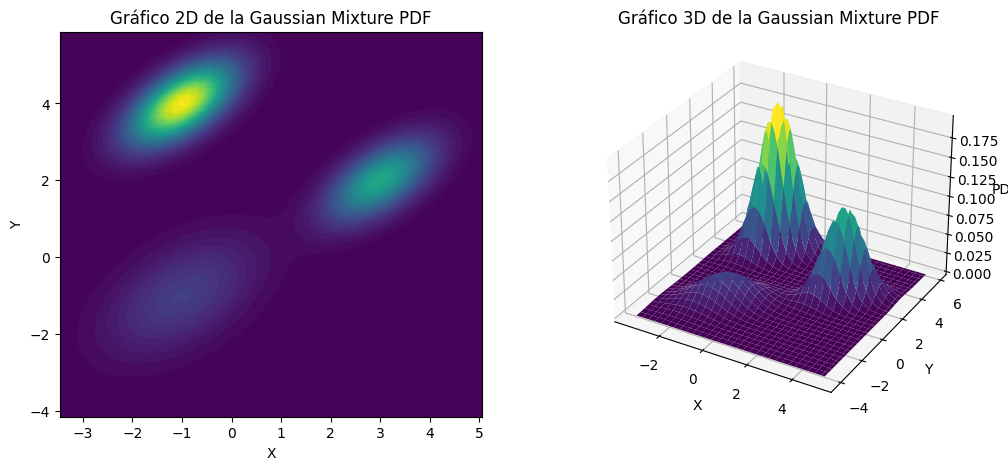

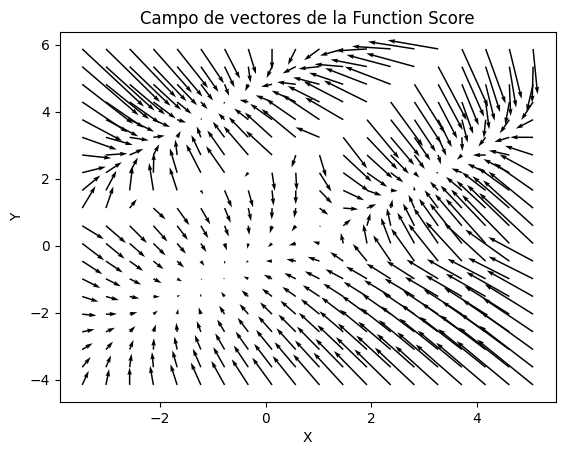

In [268]:
# Medias
means = [np.array([-1, -1]), np.array([3, 2]), np.array([-1, 4])]
# Matrices de covarianza
covariances = [np.array([[1, 0.5], [0.5, 1]]), np.array([[0.5, 0.3], [0.3, 0.5]]), np.array([[0.5, 0.3], [0.3, 0.5]])]
# Pesos
weights = [0.2, 0.3, 0.5]

# Ingresa los parámetros a la clase
gm = GaussianMixture(means, covariances, weights)

# Generamos los gráficos
gm.plot_pdf_score(scores=True,num_points=60, num_points_score=20,num_samples=1000)

A partir de lso gráficos anteriores se puede observar claramente las 3 distribuciones gaussianas, en los primeros dos gráficos se puede visualizar la PDF de la distribución, tanto en 2D como en 3D, a partir de esta se puede apreciar la disposición de las distribuciones y el efecto que tienen los pesos en ellas, principalmente en las distintas densidades que presentan cada una de ellas.

Luego, en el gráfico de la parte inferior se pueden visualizar los scores generados para esta distribución. Se puede apreciar claramente como los vectores(scores) convergergen a cada una de las distribuciones gaussianas y evidenciandose el efecto que tiene la densidad de muestras en el cálculo de los scores, ya que se puede evidenciar que los vectores se acumulan mucho más entorno a las distribuciones con más densidad o peso, mientras que la que tiene menor densidad tienden a convergerle vectores en menor cantidad. Hay que recordar que esto es uno de los problemas que presenta este algoritmo al momento de aproximar a la distribución real, debido a que en las zonas con menor densidad la aproximación es peor que en los alrededores de las zonas con mayor densidad.

d) Para el diseño del sampleo de `Langevin Dynamics` se aplicó una iteración entorno al algoritmo de actualización original planteado en los artículos y papers, es decir

$$x_{i+1} ⟵ x_{i} + ϵ\nabla_{x}\log p(x) + \sqrt(2ϵ)z_{i}$$

Para esto se utilizó una distribución prior $π(x)$ igual a una normal estándar para que la muestra inicial del algoritmo se obtenga dentro de los rangos de valores que puede obtener la mixtura de gaussianas y ayudar a la convergencia de estas muestras. El paso fijo $ϵ$ se dejó en un valor de $0.1$ y se fueron probando distintas cantidades de pasos $T$, tal como se puede ver a continuación:

Caso de T=10 pasos


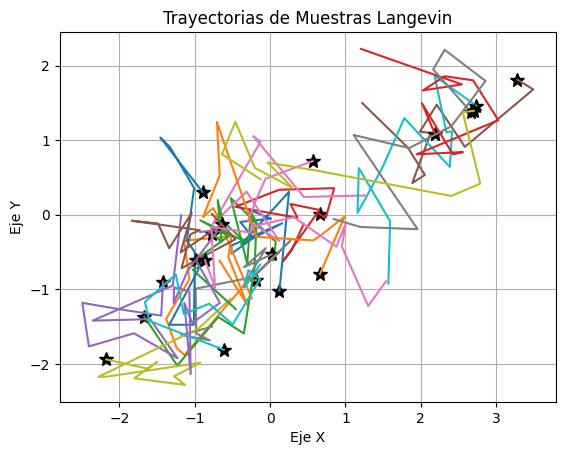

Caso de T=30 pasos


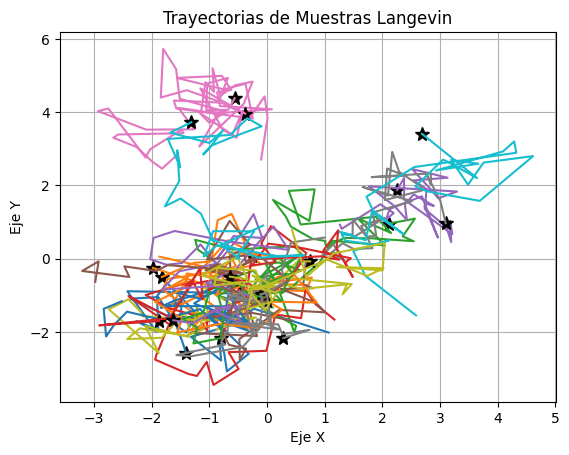

Caso de T=70 pasos


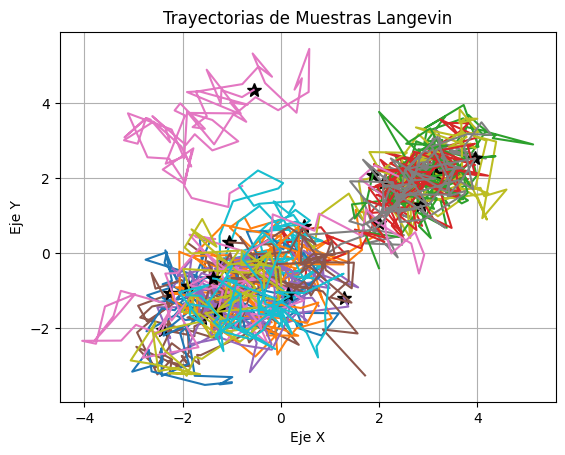

Caso de T=100 pasos


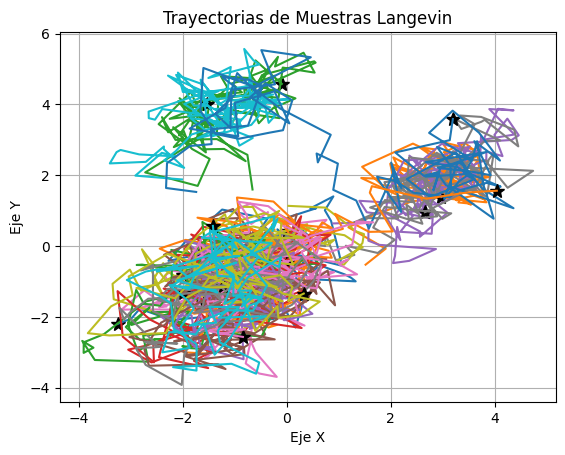

Caso de T=150 pasos


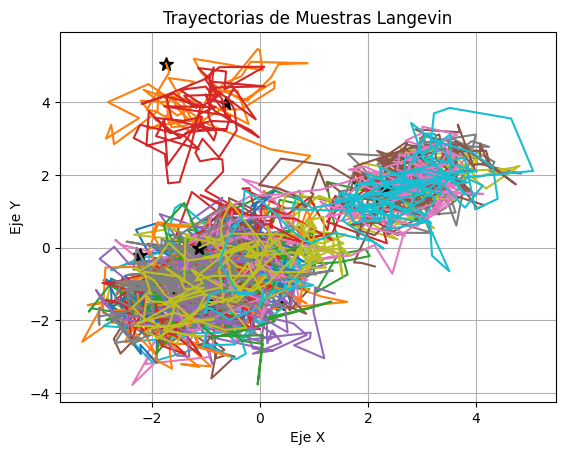

Caso de T=200 pasos


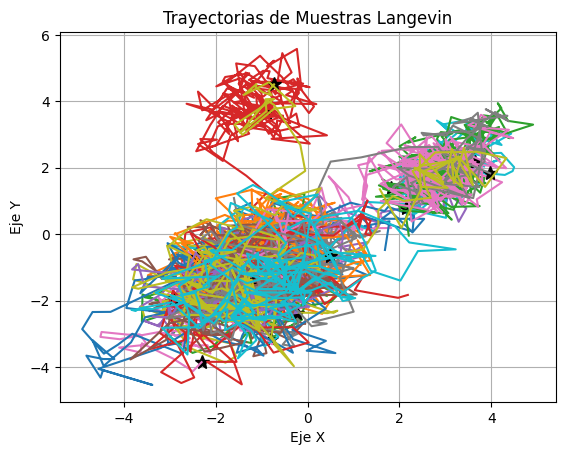

In [295]:
# Número de muestras
num_samples = 20
# Paso fijo
epsilon = 1e-1
# Cantidad de pasos
T = [10, 30, 70, 100, 150, 200]

print(f'Caso de T={T[0]} pasos')
# Generamos el muestreo de Langevin Dynamics
langevin_samples_0 = gm.langevin_samplig(num_samples=num_samples, epsilon=epsilon, T=T[0], plot=True)
print(f'Caso de T={T[1]} pasos')
# Generamos el muestreo de Langevin Dynamics
langevin_samples_1 = gm.langevin_samplig(num_samples=num_samples, epsilon=epsilon, T=T[1], plot=True)
print(f'Caso de T={T[2]} pasos')
# Generamos el muestreo de Langevin Dynamics
langevin_samples_2 = gm.langevin_samplig(num_samples=num_samples, epsilon=epsilon, T=T[2], plot=True)
print(f'Caso de T={T[3]} pasos')
# Generamos el muestreo de Langevin Dynamics
langevin_samples_3 = gm.langevin_samplig(num_samples=num_samples, epsilon=epsilon, T=T[3], plot=True)
print(f'Caso de T={T[4]} pasos')
# Generamos el muestreo de Langevin Dynamics
langevin_samples_4 = gm.langevin_samplig(num_samples=num_samples, epsilon=epsilon, T=T[4], plot=True)
print(f'Caso de T={T[5]} pasos')
# Generamos el muestreo de Langevin Dynamics
langevin_samples_5 = gm.langevin_samplig(num_samples=num_samples, epsilon=epsilon, T=T[5], plot=True)

Se probó el método con distinta cantidad de pasos y se puede ver a partir de los gráficos como el método se aplica correctamente, ya que logra actualizar las muestras inicializadas aleatoriamente hasta converger en las zonas de mayor densidad de acuerdo a los gráficos de la PDF obtenida anteriormente. Al inicio el algoritmo no es capaz de alcanzar todas las zonas de mayor densidad deibido a que la cantidad de pasos de actualización no es suficiente para las muestras alcanzen esas zonas.

Analizando un poco la forma que tiene la fórmula del método se puede entender que cada muestra en cada instante de actualización se le suma el gradiente o score factorizado por el $ϵ$, de esta forma el paso fijo es el que controla el tamaño de ese desplazamiento y el score es quien le indica la dirección hacia donde tiene que actualizarse, es por eso que al final las muestras convergen en las zonas con mayor densidad, ya que como se vió en los graficos anteriores, los vectores de los scores convergían directamente a las zonas de mayor densidad. Aismimo, al agregarle el ruido gaussiano $z_{i}$ permite darle cierto grado de aleatoriedad a la actualización y así evitar que las muestras caigan directamente en la zona con mayor densidad directamente al inicio del algoritmo, de esta forma las muestras tienen más probabilidades de abarcar más región dentro del gráfico y alcanzar otras zonas de mayor densidad.

## (P2) Denoising Score matching y Annealed Langevin

## (P3) Generalización con ecuaciones diferenciales estocásticas